# Plot CitcomCU Profiles

In [1]:
%matplotlib inline

import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
import matplotlib
from matplotlib.patches import Rectangle

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.
plt.rcParams['font.size'] = 16

In [2]:
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
fname = os.path.join(main_path,'[!m]*')
fileL = glob.glob(fname) #list of files
# [fileL.remove(file) for file in fileL if '_' in file]; 
[fileL.remove(file) for file in fileL if 'Plume' in file];
path_list = sorted (fileL, key = lambda x: (len (x), x))
fileL = [file.replace(main_path,'') for file in fileL]
ra_path = sorted (fileL, key = lambda x: (len (x), x))
ra_path2 = [float(x) for x in ra_path]
ra_path = np.sort(ra_path2)
path_list = [x for _, x in sorted(zip(ra_path2, path_list), key=lambda pair: pair[0])]
lenRa = len(ra_path2)

In [3]:
data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa):
#     fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
    if ra_path[i]=='3e8':
        fname = os.path.join(path_list[i]+'\\512\\','[!m]*.txt')
    else:
        fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
    fileL = glob.glob(fname) #list of files
    temp = []
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=None)
        b.rename(columns={0:a}, inplace=True)
        temp.append(b)
    c = b.copy()
    c.values[:] = ra_path[i]
    temp.append(c)
    toDF = np.reshape(temp,(4,257),order='A')
    DF = pd.DataFrame(toDF.T)
    DF.rename(columns={0:'Radius',2:'Temperature',1:'Velocity',3:'Ra'},inplace=True)
    data[i] = DF

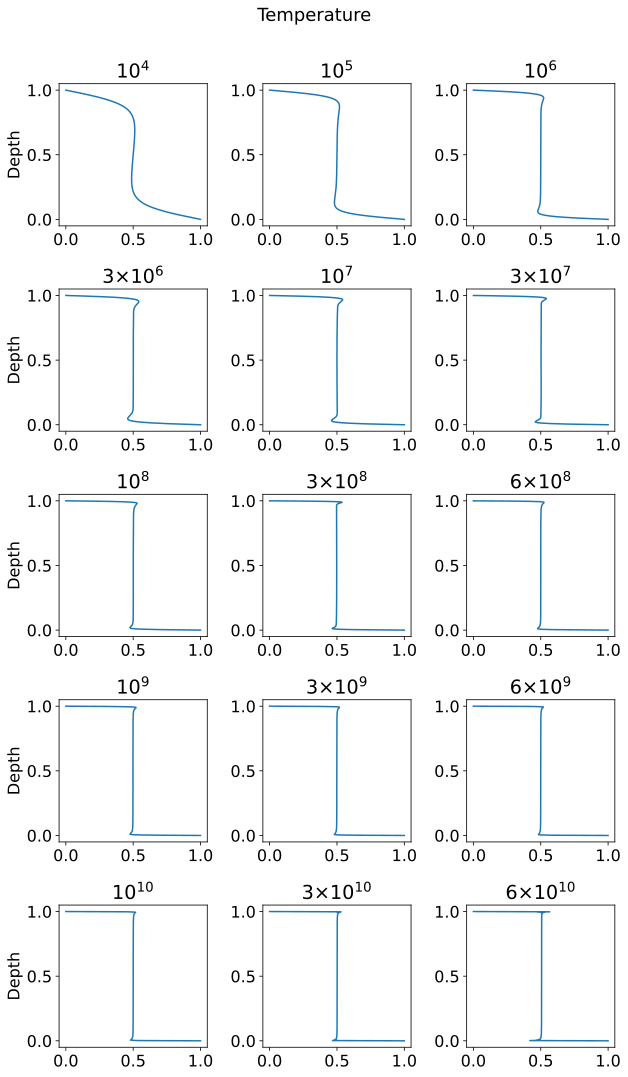

In [4]:
fig = plt.figure(figsize=(9,15))
plt.suptitle("Temperature", fontsize=18, y = 1.0)

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

for i in range(lenRa):
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, i + 1)
    plt.plot(data[i]['Temperature'],data[i]['Radius'])
    if i%3 == 0:
        plt.ylabel('Depth')
#     print(data[i]['Ra'].head(1))
    ax.set_title('{}'.format(fmt(float(ra_path[i]))))
    # ax.set_title(f"{float(ra_path[i]):.1e}")
# fig.text(-0.01, 0.5, 'Depth', va='center', rotation='vertical', fontsize=14)
fig.tight_layout()

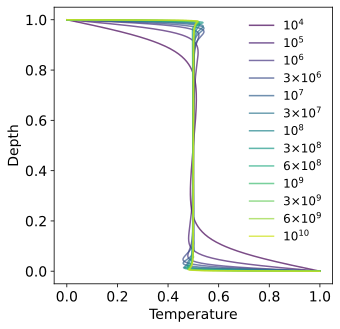

In [5]:
fig = plt.figure(figsize=(5,5))
cmap = plt.get_cmap('viridis');
for i in range(lenRa-2):
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),\
             color=cmap(i/(lenRa-2)),alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.ylabel('Depth')
plt.xlabel('Temperature');

image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'Temperature profiles overlayed.png',pad_inches=0.1,bbox_inches='tight');

In [6]:
def zoom_outside(srcax, roi, dstax, color="red", linewidth=2, roiKwargs={}, arrowKwargs={}):
    '''Create a zoomed subplot outside the original subplot
    
    srcax: matplotlib.axes
        Source axis where locates the original chart
    dstax: matplotlib.axes
        Destination axis in which the zoomed chart will be plotted
    roi: list
        Region Of Interest is a rectangle defined by [xmin, ymin, xmax, ymax], all coordinates are expressed in the 
        coordinate system of data
    roiKwargs: dict (optional)
        Properties for matplotlib.patches.Rectangle given by keywords
    arrowKwargs: dict (optional)
        Properties used to draw a FancyArrowPatch arrow in annotation
    '''
    roiKwargs = dict([("fill", False), ("linestyle", "dashed"), ("color", color), ("linewidth", linewidth)]
                     + list(roiKwargs.items()))
    arrowKwargs = dict([("arrowstyle", "-"), ("color", color),  ("linewidth", linewidth)] + list(arrowKwargs.items()))
    
    # draw a rectangle on original chart
    srcax.add_patch(Rectangle([roi[0], roi[1]], roi[2]-roi[0], roi[3]-roi[1], **roiKwargs))
    # get coordinates of corners
    srcCorners = [[roi[0], roi[1]], [roi[0], roi[3]],[roi[2], roi[1]], [roi[2], roi[3]]]
    dstCorners = dstax.get_position().corners()
    srcBB = srcax.get_position()
    dstBB = dstax.get_position()
    
    # find corners to be linked
    if srcBB.max[0] <= dstBB.min[0]: # right side
        if srcBB.min[1] < dstBB.min[1]: # upper
            corners = [1, 2]
        elif srcBB.min[1] == dstBB.min[1]: # middle
            corners = [0, 1]
        else:
            corners = [0, 3] # lower
    elif srcBB.min[0] >= dstBB.max[0]: # left side
        if srcBB.min[1] < dstBB.min[1]:  # upper
            corners = [0, 3]
        elif srcBB.min[1] == dstBB.min[1]: # middle
            corners = [2, 3]
        else:
            corners = [1, 2]  # lower
    elif srcBB.min[0] == dstBB.min[0]: # top side or bottom side
        if srcBB.min[1] < dstBB.min[1]:  # upper
            corners = [0, 2]
        else:
            corners = [1, 3] # lower
    else:
        RuntimeWarning("Cannot find a proper way to link the original chart to the zoomed chart!" 
                       "The lines between the region of interest and the zoomed chart wiil not be plotted.")
        return
    # plot 2 lines to link the region of interest and the zoomed chart
    for k in range(2):
        srcax.annotate('', xy=srcCorners[corners[k]], xycoords="data",
            xytext=dstCorners[corners[k]], textcoords="figure fraction",
            arrowprops=arrowKwargs)

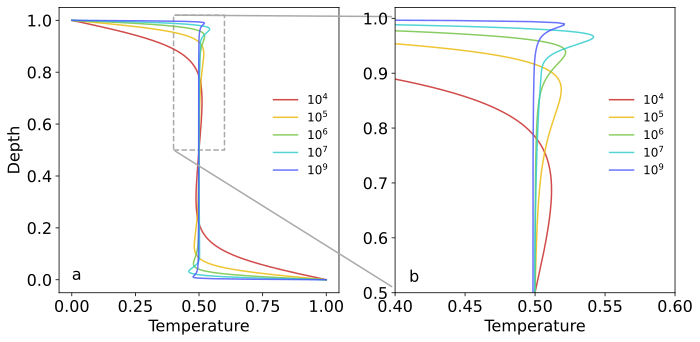

In [12]:
fig = plt.figure(figsize=(10,5))
colors = ['#c92c2c','#ebbb10','#75c447','#33cccc','#4e5afc','#bb4ae0']
selected = [0,1,2,4,9]
ax1 = plt.subplot(1,2,1)
j = 0;
for i in selected:
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),color=colors[j],alpha=0.85)
    j+=1
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.ylabel('Depth')
plt.xlabel('Temperature');
plt.text(0,0,'a')

ax2 = plt.subplot(1,2,2)
j = 0;
for i in selected:
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),color=colors[j],alpha=0.85)
    j+=1
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.xlim(0.4,0.6)
plt.ylim(0.5,1.02)
plt.xlabel('Temperature');
plt.text(0.41,0.52,'b')
fig.tight_layout()

zoom_outside(srcax=ax1, roi=[0.4, 0.5, 0.6, 1.02], dstax=ax2, color='darkgrey', linewidth=1.5)

image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'Temperature profiles overlayed selected.png',pad_inches=0.1,bbox_inches='tight');

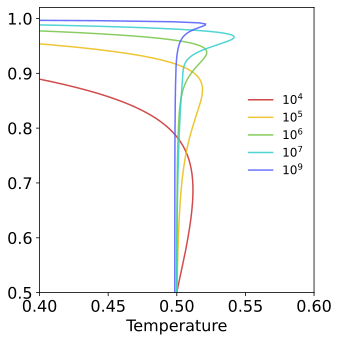

In [14]:
fig = plt.figure(figsize=(5,5))
colors = ['#c92c2c','#ebbb10','#75c447','#33cccc','#4e5afc','#bb4ae0']
selected = [0,1,2,4,9]
j = 0;
for i in selected:
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),color=colors[j],alpha=0.85)
    j+=1
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.xlim(0.4,0.6)
plt.ylim(0.5,1.02)
plt.xlabel('Temperature');
fig.tight_layout()
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'Temperature profiles overlayed selected zoom.svg',pad_inches=0.1,bbox_inches='tight');

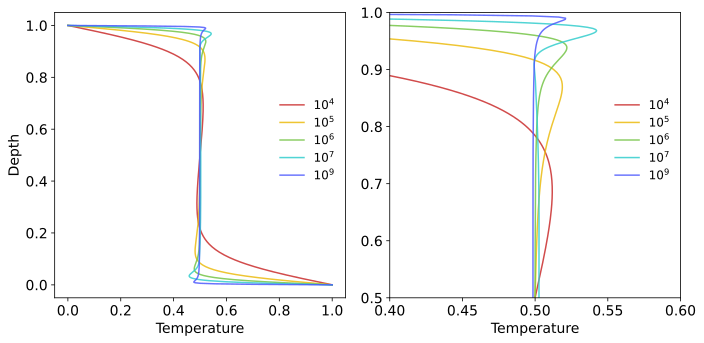

In [55]:
fig = plt.figure(figsize=(10,5))
colors = ['#c92c2c','#ebbb10','#75c447','#33cccc','#4e5afc','#bb4ae0']
selected = [0,1,2,4,9]
ax = plt.subplot(1,2,1)
j = 0;
for i in selected:
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),color=colors[j],alpha=0.85)
    j+=1
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.ylabel('Depth')
plt.xlabel('Temperature');

ax = plt.subplot(1,2,2)
j = 0;
for i in selected:
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),color=colors[j],alpha=0.85)
    j+=1
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
# plt.title('Temperature Profiles Overlayed')
plt.xlim(0.4,0.6)
plt.ylim(0.5,1)
plt.xlabel('Temperature');
fig.tight_layout()

image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'Temperature profiles overlayed selected.png',pad_inches=0.1,bbox_inches='tight');

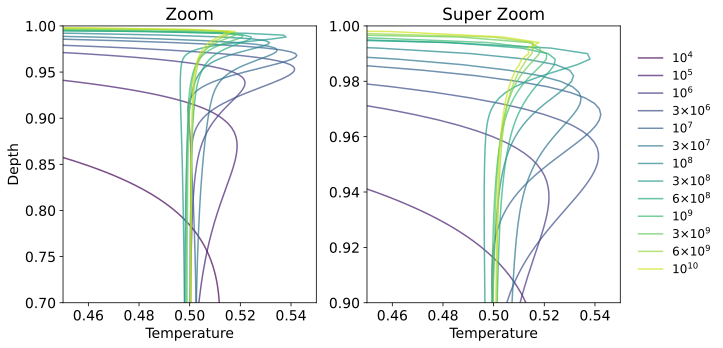

In [13]:
fig = plt.figure(figsize=(10,5))
cmap = plt.get_cmap('viridis');

ax = plt.subplot(1,2,1)
for i in range(lenRa-2):
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),\
             color=cmap(i/(lenRa-2)),alpha=0.7)
# plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1, 0.55));
plt.xlim(0.45,0.55)
plt.ylim(0.7,1)
plt.title('Zoom')
plt.ylabel('Depth')
plt.xlabel('Temperature');

ax = plt.subplot(1,2,2)
for i in range(lenRa-2):
    plt.plot(data[i]['Temperature'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),\
             color=cmap(i/(lenRa-2)),alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1.4, 0.5));
plt.xlim(0.45,0.55)
plt.ylim(0.9,1)
plt.title('Super Zoom')
plt.xlabel('Temperature');

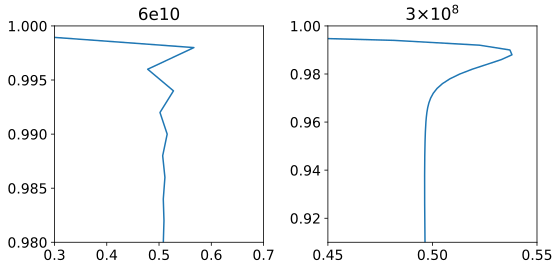

In [144]:
fig = plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
plt.plot(data[14]['Temperature'],data[lenRa-1]['Radius']);
plt.ylim(0.98,1)
plt.xlim(0.3,0.7)
plt.title('6e10')

ww=7
ax2 = plt.subplot(122)
plt.plot(data[ww]['Temperature'],data[lenRa-1]['Radius']);
plt.ylim(0.91,1)
plt.xlim(0.45,0.55)
plt.title('{}'.format(fmt(float(ra_path[ww]))))

fig.tight_layout()

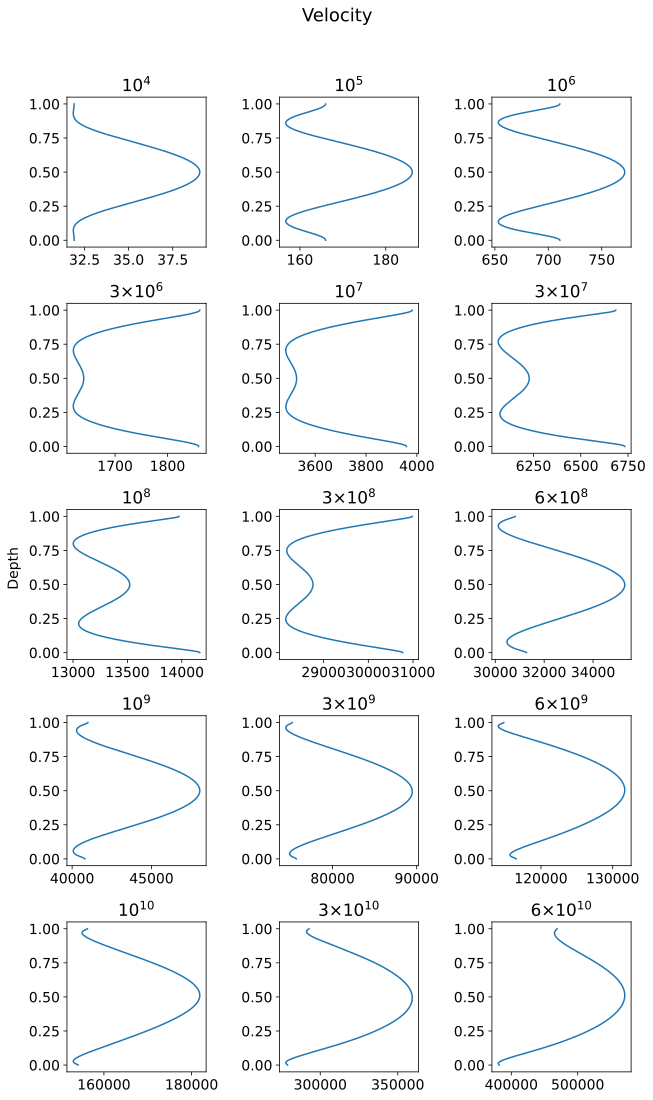

In [17]:
fig = plt.figure(figsize=(9,15))
plt.suptitle("Velocity", fontsize=18, y = 1.02)

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

for i in range(lenRa):
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, i + 1)
    plt.plot(data[i]['Velocity'],data[i]['Radius'])
    ax.set_title('{}'.format(fmt(float(ra_path[i]))))
fig.text(-0.01, 0.5, 'Depth', va='center', rotation='vertical', fontsize=14)
fig.tight_layout()

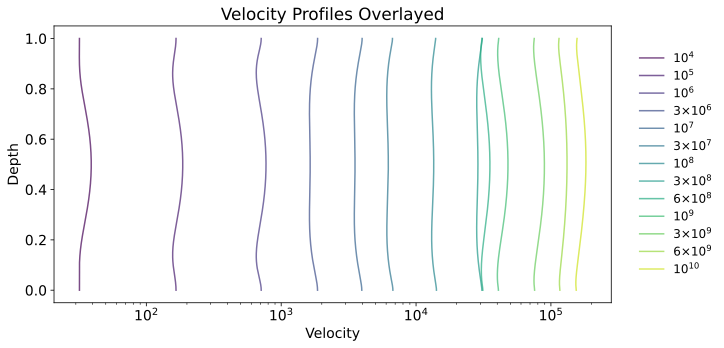

In [18]:
fig = plt.figure(figsize=(10,5))
cmap = plt.get_cmap('viridis');
for i in range(lenRa-2):
    plt.plot(data[i]['Velocity'],data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),\
             color=cmap(i/(lenRa-2)),alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1.2, 0.5));
plt.title('Velocity Profiles Overlayed')
plt.ylabel('Depth')
plt.xlabel('Velocity');
plt.xscale('log');

In [19]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

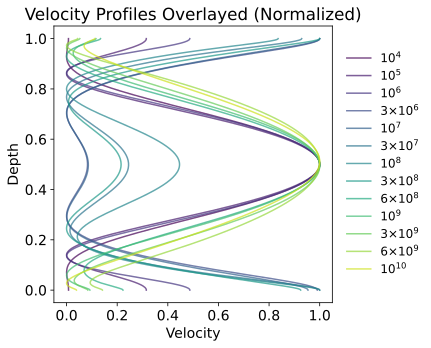

In [20]:
fig = plt.figure(figsize=(5,5))
cmap = plt.get_cmap('viridis');
for i in range(lenRa-2):
    velo = (data[i]['Velocity']-data[i]['Velocity'].min())/(data[i]['Velocity'].max()-data[i]['Velocity'].min())
    plt.plot(velo,data[i]['Radius'],label=('{}'.format(fmt(float(ra_path[i])))),\
             color=cmap(i/(lenRa-2)),alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1.35, 0.5));
plt.title('Velocity Profiles Overlayed (Normalized)')
plt.ylabel('Depth')
plt.xlabel('Velocity');